# Neural Artistic Style Transfer

This interactive notebook shows how to use the python package `style` for performing artistic style transfer between a source and a style image. 

Based on the work of

> Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). 
> A neural algorithm of artistic style. 
> https://arxiv.org/abs/1508.06576

Also incorporating ideas from

> Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). 
> Perceptual losses for real-time style transfer and super-resolution. 
> In European Conference on Computer Vision (pp. 694-711). Springer, Cham.
> https://arxiv.org/abs/1603.08155


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import torch
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

Import style

In [111]:
import style
st = style.IteratedStyleTransfer()

### Visualizing Style Transfer

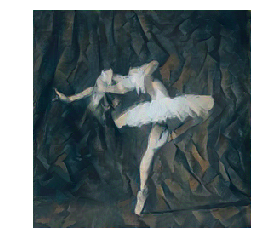

In [29]:
p = style.image.open('etc/dancing.jpg')
a = style.image.open('etc/picasso.jpg')
p = style.image.resize(p, (256,256))
a = style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,8,12]] = 1

# get a generator object
g = st.iterate(p, a, c_id, style_weights, niter=500, lr=1e-2, x=p);

# and iterate (yields every 50 iterations)
fig, ax = plt.subplots()
img = ax.imshow(np.zeros_like(p))
ax.set_axis_off()

for x, l in g:
    clear_output(wait=True)
    img.set_data(x)
    display(fig)
clear_output(wait=True)



## Multiscale

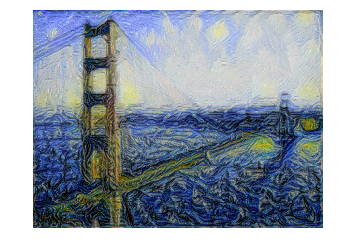

In [30]:
p = style.image.open('etc/bridge.JPG')
a = style.image.open('etc/vangogh.jpg')

sizes = style.image.Pyramid.image_sizes(p.shape, 4)[:-1]
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[2,4,8,12]] = [1, 1, 0.6, 0.2]

imgs = []
for x,_ in st.iterate_multiscale(p, a, cid, style_weights, sizes, x=p, niter=100):
    imgs.append(x)
clear_output(wait=True)

imgs = [style.image.resize(img, sizes[-1]) for img in imgs]
data = np.hstack(imgs)
style.image.save('style.png', data)

plt.imshow(imgs[-1])
plt.axis('off')
plt.show()    

## Seamless

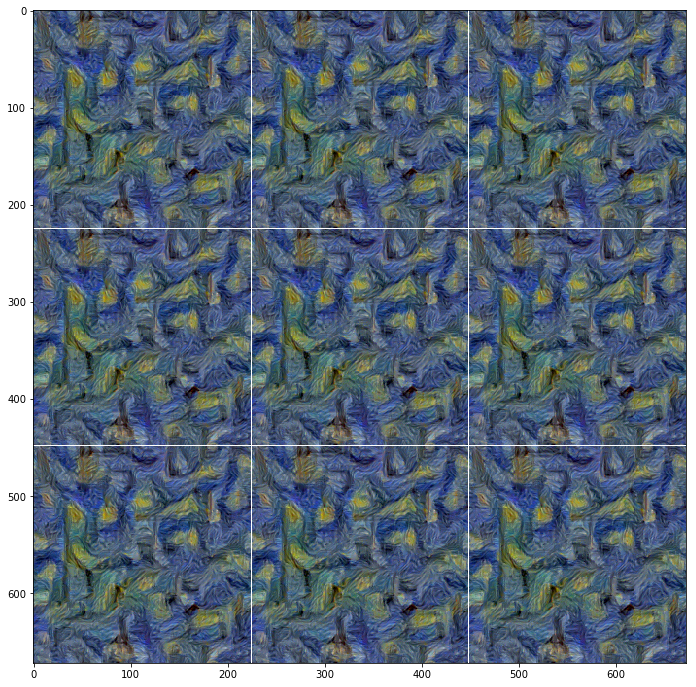

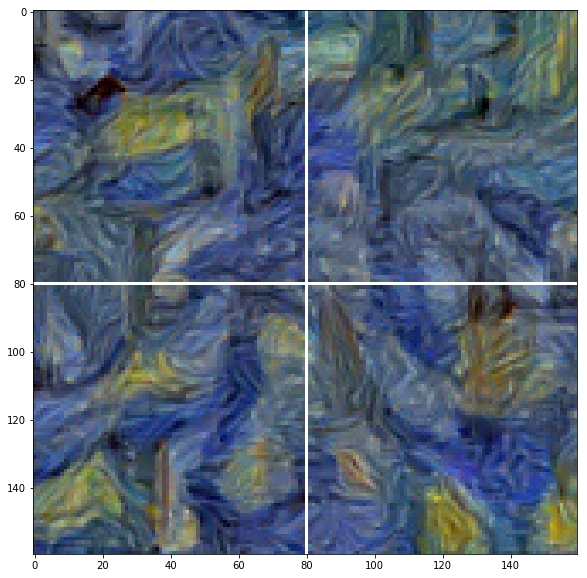

In [128]:
a = style.image.open('etc/vangogh.jpg')
a = style.image.resize(a, (256,256))

np.random.seed(456)
torch.manual_seed(456)

sizes = style.image.Pyramid.image_sizes(a.shape, 3)
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,6,8]] = [1]

border = 16
seamless = style.plugins.SeamlessPlugin(a.shape, border)

x,_ = st.run_multiscale(a, a, cid, style_weights, sizes, niter=100, weight_content_loss=0, plugins=[seamless])
x = style.image.borderless_view(x, border)
clear_output(wait=True)

def gen_grid(x, border=True):
    hs = np.hstack((x,x,x))
    vs = np.vstack((hs,hs,hs))

    if border:
        h,w = x.shape[:2]       
        vs[:, [w,2*w]] = 1
        vs[[h,2*h]]=1

    return vs
        
gb = gen_grid(x, border=True)
g = gen_grid(x, border=False)
plt.figure(figsize=(12,12))
plt.imshow(gb)
plt.show()

plt.imshow(gb[144:304,144:304])
plt.show()


In [59]:
style.image.save('seamless_border.png', gb)
style.image.save('seamless.png', g)

## Creating larger textures

100%|████████████████████████████████████| 4/4 [00:09<00:00,  2.46s/it, loss=[1.027e-04 0.000e+00 1.018e-04 9.416e-07]]


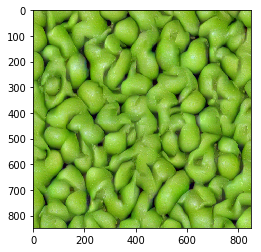

In [16]:
a = style.image.open('apples.png')
a = style.image.resize(a, (512,512))

# Make sure we all see the same
torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[8,10]] = 1

g = style.GridSynthesis(st, (2,2), (512,512,3), s=32, b=48)
x = g.generate(a, c_id, style_weights, niter=80)
plt.imshow(x)

In [17]:
style.image.save('final.png', x)

In [97]:
from style.plugins import Plugin

class Tiling:
    
    def __init__(self, st):
        self.st = st
        
    def generate(self, seed, grid_shape, border=32, **kwargs):
        final_shape = seed.shape
        tile_shape = (final_shape[0]//grid_shape[0], final_shape[1]//grid_shape[1], 3)
        
        seed = np.pad(seed, ((border,border),(border,border),(0,0)), 'reflect')
        unused = np.zeros_like(seed)
        final = np.empty(final_shape, np.float32)
        
        for row in range(grid_shape[0]):
            for col in range(grid_shape[1]):
                
                sr = tile_shape[0] * row
                er = tile_shape[0] * (row+1) + 2*border
                sc = tile_shape[1] * col
                ec = tile_shape[1] * (col+1) + 2*border

                tile,_ = self.st.run(seed[sr:er,sc:ec], a, c_id, style_weights, x=np.array(seed[sr:er,sc:ec]), weight_content_loss=0, **kwargs)
                
                sr = tile_shape[0] * row
                er = tile_shape[0] * (row+1)
                sc = tile_shape[1] * col
                ec = tile_shape[1] * (col+1)
                final[sr:er,sc:ec] = style.image.borderless_view(tile, border)
        
        return final
        
        
        

In [106]:
a = style.image.open('etc/picasso.jpg')
torch.manual_seed(456)
np.random.seed(456)

c_id = st.conv_ids[6]
style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,8]] = 1

def random_start(a, shape):
    init = a.mean((0,1), keepdims=True)
    init = init + np.random.randn(*shape).astype(np.float32)*1e-2
    return init 

t = Tiling(st)

100%|███████████████████████| 100/100 [00:01<00:00, 61.58it/s, loss=[3.859e-04 0.000e+00 3.844e-04 1.476e-06], lr=0.01]


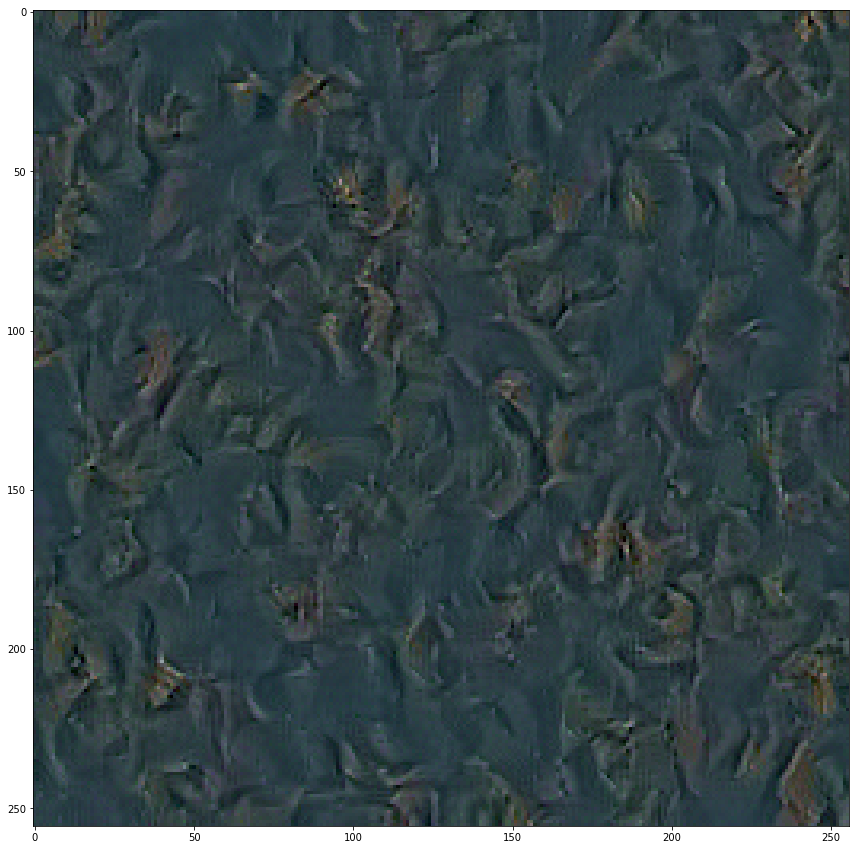

In [114]:
x = t.generate(random_start(a, (256,256,3)), (2,2), border=64, niter=100)
#x = style.image.resize(x, (512,256))
#x = t.generate(x, (1,2), border=2)
#x = style.image.resize(x, (512,512))
#x = t.generate(x, (4,4), border=20)
#x = style.image.resize(x, (1024,1024))
#x = t.generate(x, (2,2), border=20)

plt.figure(figsize=(15,15))
plt.imshow(x)
plt.show()

In [64]:
style.image.save('x.png', x)

In [51]:
a = style.image.open('etc/picasso.jpg')
#style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(456)
np.random.seed(456)

c_id = st.conv_ids[12]
style_weights = np.zeros(len(st.conv_ids))
style_weights[[8,12]] = 1

def random_start(a, shape):
    init = a.mean((0,1), keepdims=True)
    init = init + np.random.randn(*shape).astype(np.float32)*1e-2
    return init  


def generate(a, seed=None, shape=None, b=20):
    if shape is not None:
        seed = random_start(a, shape)
    else:
        shape = seed.shape
    unused = np.zeros(shape, dtype=np.float32)
    
    wh = shape[0]//2
    x1,_ = st.run(unused[:,:wh+b], a, c_id, style_weights, niter=80, x=np.array(seed[:,:wh+b]))
    x2,_ = st.run(unused[:,wh-b:], a, c_id, style_weights, niter=80, x=np.array(seed[:,wh-b:]))
    
    return np.hstack((x1[:,:-b],x2[:,b:]))


#x,_ = st.run(unused, a, c_id, style_weights, niter=100, x=seed, weight_tv_loss=0)
x00 = generate(a, shape=(64,128,3), b=20)
style.image.save('x00.png',x00)

x01 = x00.copy()
x01[:, x00.shape[1]//2] = 1
style.image.save('x01.png', x01)


x10 = generate(a, seed=style.image.resize(x00, (256, 128)), b=20)
style.image.save('x10.png',x10)

x11 = x10.copy()
x11[:, x10.shape[1]//2] = 1
x11[:, x10.shape[1]//2+10] = 1
x11[:, x10.shape[1]//2-10] = 1
style.image.save('x11.png', x11)


x20 = generate(a, seed=style.image.resize(x10, (512, 256)), b=20)
style.image.save('x20.png', x20)

x21 = x20.copy()
x21[:, x20.shape[1]//2] = 1
x21[:, x20.shape[1]//2+10] = 1
x21[:, x20.shape[1]//2-10] = 1
style.image.save('x21.png', x21)


x30 = generate(a, seed=style.image.resize(x20, (1024, 512)), b=20)
style.image.save('x30.png', x30)

x31 = x30.copy()
x31[:, x30.shape[1]//2] = 1
x31[:, x30.shape[1]//2+10] = 1
x31[:, x30.shape[1]//2-10] = 1
style.image.save('x31.png', x31)


x40 = generate(a, seed=style.image.resize(x30, (2048, 1024)), b=20)
style.image.save('x40.png', x40)

#x31 = x30.copy()
#x31[:, x30.shape[1]//2] = 1
#x31[:, x30.shape[1]//2+10] = 1
#x31[:, x30.shape[1]//2-10] = 1
#style.image.save('x31.png', x31)

#plt.figure(figsize=(12,12))
#plt.imshow(abs(x11-x22))
#plt.imshow(x2)
#plt.show()




#plt.figure(figsize=(12,12))
#plt.imshow(abs(x11-x22))
#plt.imshow(x2)
#plt.show()

 66%|████████████████▌        | 53/80 [00:02<00:01, 20.95it/s, loss=[6.767e-04 2.107e-04 4.644e-04 1.553e-06], lr=0.01]


KeyboardInterrupt: 

[(80, 64), (160, 128), (320, 256)]
16


100%|████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s, loss=[4.251e-04 1.750e-04 2.491e-04 1.010e-06]]


(256, 512, 3)


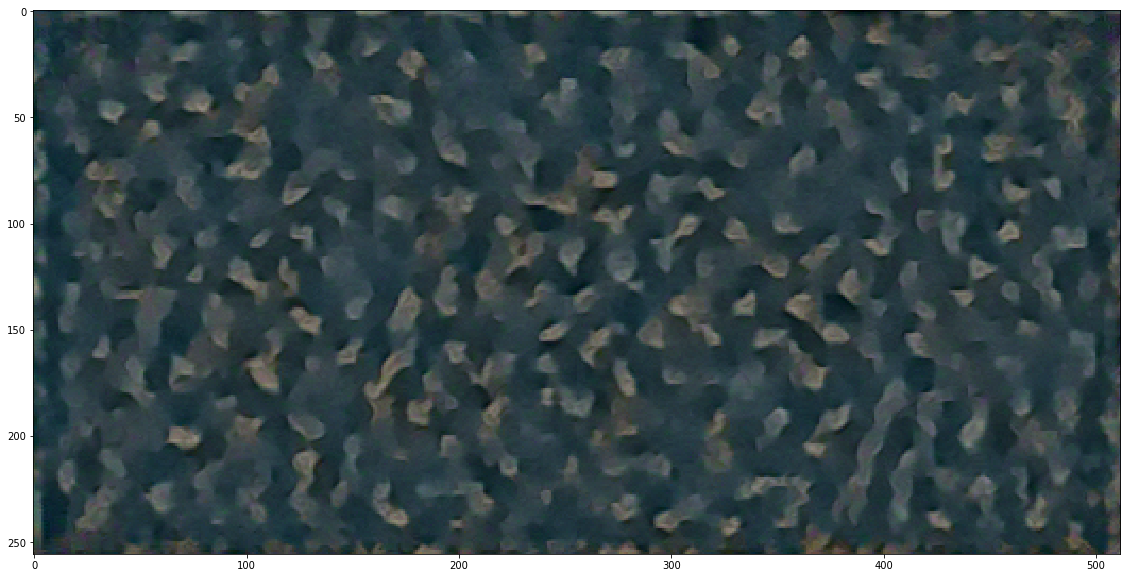

In [20]:
a = style.image.open('etc/picasso.jpg')
a = style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(123)
np.random.seed(123)

c_id = st.conv_ids[12]
style_weights = np.zeros(len(st.conv_ids))
style_weights[[1,2]] = 1

def random_start(a, shape):
    init = a.mean((0,1), keepdims=True)
    init = init + np.random.randn(*shape).astype(np.float32)*1e-2
    return init  


seed = random_start(a, (64,128,3))
unused = np.zeros((64,128,3), dtype=np.float32)

b = 64
bsl = b//(2**2)
ts = style.image.Pyramid.image_sizes((256,256+b), 3)
tsl = ts[0]

print(ts)
print(bsl)


x1,_ = st.run_multiscale(unused[:,:tsl[0]], a, c_id, style_weights, ts, niter=20, x=np.array(seed[:,:tsl[0]]))
x2,_ = st.run_multiscale(unused[:,tsl[0]-2*bsl:], a, c_id, style_weights, ts, niter=20, x=np.array(seed[:,tsl[0]-2*bsl:]))

x12 = np.hstack((x1[:,:-b],x2[:,b:]))
print(x12.shape)
plt.figure(figsize=(20,10))
plt.imshow(x12)
plt.show()

"""
seed = random_start(a, (256,512,3))
unused = np.zeros((256,512,3), dtype=np.float32)

#x,_ = st.run_multiscale(unused, a, c_id, style_weights, [(256,128),(512,256)],niter=20, x=seed)

b=64
x1,_ = st.run_multiscale(unused[:,:256+b], a, c_id, style_weights, [(64+b//4, 64),(128+b//2,128)], niter=50, x=np.array(seed[:,:256+b]))
x2,_ = st.run_multiscale(unused[:,256-b:], a, c_id, style_weights, [(64+b//4, 64),(128+b//2,128)], niter=50, x=np.array(seed[:,256-b:]))

print(x1.shape)

x12 = np.hstack((x1[:,:-b//2],x2[:,b//2:]))
print(x12.shape)
x12b = x12.copy()
x12b[:, 128] = 1

plt.figure(figsize=(12,12))
#plt.imshow(abs(x11-x22))
plt.imshow(x)
plt.show()

plt.figure(figsize=(12,12))
#plt.imshow(abs(x11-x22))
plt.imshow(x12)
plt.show()

plt.figure(figsize=(12,12))
#plt.imshow(abs(x11-x22))
plt.imshow(x12b)
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(abs(x.mean(-1)-x12.mean(-1)))
plt.colorbar()
plt.show()

style.image.save('x.png', x)
style.image.save('x12.png', x12)
style.image.save('x12b.png', x12b)
""";



style.image.save('x1.png', x1)
style.image.save('x2.png', x2)
style.image.save('x1part.png', x1[:,:-b])
style.image.save('x2part.png', x2[:,b:])
style.image.save('x12.png', x12)
